# Prepare
## Dataset loading

In [482]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import Callback
from tqdm import tqdm
from scipy.interpolate import interp1d

train_raw = pd.read_excel('/home/competition/data/data/ai_competition_train.xlsx')
test_raw = pd.read_excel('/home/competition/data/data/ai_competition_test.xlsx')

train = np.array(train_raw['flux'])
test = np.array(test_raw['flux'])

print(train.shape, test.shape)

#windows shift
INPUT_DAYS = 60


(5479,) (60,)


### NaN to zeros

In [483]:
def nan_to_zero(_input):        
    print("1. NaN 값의 개수:", np.sum(np.isnan(_input)), "개는 0으로 대체되었음.")
    nan_indices = np.isnan(train)
    _mask = np.zeros(len(train))
    _input[nan_indices] = _mask[nan_indices]
    return _input, nan_indices


### Cut zeros

In [484]:
def cut_zeros(_data):
    print("2. before cut : ", _data.shape)
    _data_cut = _data[_data != 0]
    print("3. after cut : ", _data_cut.shape)
    return _data_cut

### Make dataset windows shift

In [485]:
def make_dataset_windowsshift(_input, window_size=INPUT_DAYS):
    assert min(_input) > 0
    # subtract mean
    _data = _input.copy()
    
    _data_submean = _data - np.mean(_data)
    
    train_x = np.zeros([INPUT_DAYS, 1])
    train_y = np.zeros([1, 1])

    #print("x and y shape :", train_x.shape, train_y.shape)
    for i in range(len(_data_submean) - INPUT_DAYS - 1):
        train_x = np.concatenate(
            (train_x, _data_submean[i:i+INPUT_DAYS, np.newaxis]), axis=1)
        train_y = np.concatenate(
            (train_y, _data_submean[np.newaxis, i+INPUT_DAYS+1, np.newaxis]), axis=1)

    #print("x and y shape :", train_x.shape, train_y.shape)
    train_x = train_x[:, 1:]
    train_y = train_y[:, 1:]
    train_x = train_x.T
    train_y = train_y.T
    print("dataset shape : ", train_x.shape, train_y.shape)
    
    return train_x, train_y


### linear interpolation and replace

In [486]:
def linear_interpolation_with_replace(_input, _original, _nan_idx):
    
    interp_func = interp1d(np.arange(len(_input)), _input, kind='linear')
    # 보간된 데이터 생성
    data_5479 = interp_func(np.linspace(0, len(_input) - 1, len(_original)))

    # 원본 배열 (5479,) - NaN 값이 포함된 배열 (예시로 임의의 데이터 사용)
    interpolated = _original.copy()

    # NaN 위치에 A의 동일 인덱스 값 대입
    interpolated[_nan_idx] = data_5479[_nan_idx]
    print("4. interpolation shape : ", train_intered.shape)
    return interpolated

1. NaN 값의 개수: 1251 개는 0으로 대체되었음.
2. before cut :  (5479,)
3. after cut :  (4228,)
4. interpolation shape :  (5479,)


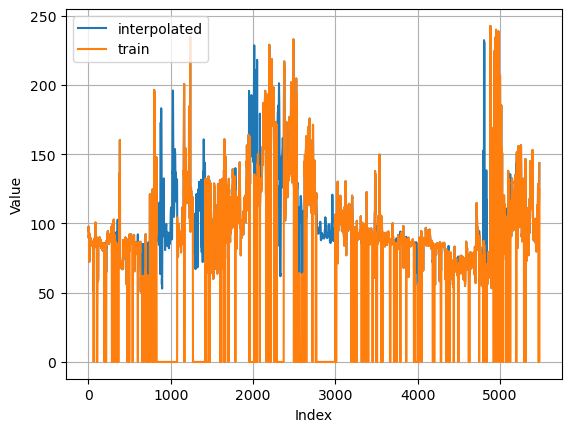

dataset shape :  (4167, 60) (4167, 1)
dataset shape :  (5418, 60) (5418, 1)
(9585, 60) (9585, 1)


In [487]:
train = np.array(train_raw['flux'])

train_zeros, _nan_idx = nan_to_zero(train)
train_cut = cut_zeros(train_zeros)
train_intered = linear_interpolation_with_replace(train_cut, train, _nan_idx)



plt.figure()
plt.plot(train_intered, label='interpolated')
plt.plot(train, label='train')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

train_x1, train_y1 = make_dataset_windowsshift(train_cut)
train_x2, train_y2 = make_dataset_windowsshift(train_intered)
train_x = np.concatenate((train_x1, train_x2), axis=0)
train_y = np.concatenate((train_y1, train_y2), axis=0)
print(train_x.shape, train_y.shape)


---

# Model

### Define model

In [488]:
loss_history = []


class LossHistory(Callback):
    def on_epoch_end(self, epoch, logs=None):
        loss_history.append(logs['loss'])


loss_callback = LossHistory()


# RMSE 손실 함수 정의
def rmse_loss(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred), axis=-1))


def create_lstm_model(input_shape):
    model = keras.Sequential()
    model.add(keras.layers.LSTM(units=50, input_shape=input_shape, return_sequences=True))  # 첫 번째 LSTM 레이어
    model.add(keras.layers.LSTM(units=50, return_sequences=True))  # 두 번째 LSTM 레이어
    model.add(keras.layers.LSTM(units=50))  
    model.add(keras.layers.Dense(20, activation='relu'))
    model.add(keras.layers.Dense(1))
    model.compile(optimizer='adam', loss=rmse_loss)
    return model


# def create_lstm_model(input_shape):
#     model = keras.Sequential()
#     # 입력 데이터를 평평하게 펼칩니다.
#     model.add(keras.layers.Flatten(input_shape=input_shape))
#     # 20개의 유닛을 가진 일반적인 Dense 레이어
#     model.add(keras.layers.Dense(20, activation='relu'))
#     model.add(keras.layers.Dense(20, activation='relu'))
#     model.add(keras.layers.Dense(20, activation='relu'))
#     model.add(keras.layers.Dense(5, activation='relu'))
#     model.add(keras.layers.Dense(1))  # 출력 레이어
#     model.compile(optimizer='adam', loss='mean_squared_error',
#                   metrics=['RootMeanSquaredError'])
#     return model


## First training

In [489]:
input_shape = (INPUT_DAYS, 1)
first_lstm_model = create_lstm_model(input_shape)
first_lstm_model.summary()

Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_68 (LSTM)              (None, 60, 50)            10400     
                                                                 
 lstm_69 (LSTM)              (None, 60, 50)            20200     
                                                                 
 lstm_70 (LSTM)              (None, 50)                20200     
                                                                 
 dense_101 (Dense)           (None, 20)                1020      
                                                                 
 dense_102 (Dense)           (None, 1)                 21        
                                                                 
Total params: 51841 (202.50 KB)
Trainable params: 51841 (202.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [490]:
start_time = time.time()
first_lstm_model.fit(train_x, train_y, epochs=30, batch_size=64, callbacks=[loss_callback])
print(f"코드 실행 시간: {start_time-time.time()} 초")


Epoch 1/30


150/150 [==============================] - 19s 91ms/step - loss: 15.4446
Epoch 2/30
150/150 [==============================] - 14s 90ms/step - loss: 8.4349
Epoch 3/30
150/150 [==============================] - 13s 89ms/step - loss: 7.3794
Epoch 4/30
150/150 [==============================] - 13s 89ms/step - loss: 7.0473
Epoch 5/30
150/150 [==============================] - 14s 91ms/step - loss: 6.9385
Epoch 6/30
150/150 [==============================] - 13s 88ms/step - loss: 6.7945
Epoch 7/30
150/150 [==============================] - 13s 87ms/step - loss: 6.6904
Epoch 8/30
150/150 [==============================] - 13s 88ms/step - loss: 6.6851
Epoch 9/30
150/150 [==============================] - 13s 89ms/step - loss: 6.5307
Epoch 10/30
150/150 [==============================] - 13s 88ms/step - loss: 6.5346
Epoch 11/30
150/150 [==============================] - 13s 89ms/step - loss: 6.4551
Epoch 12/30
150/150 [==============================] - 13s 90ms/step - loss: 6.4148
Epoch 13/30

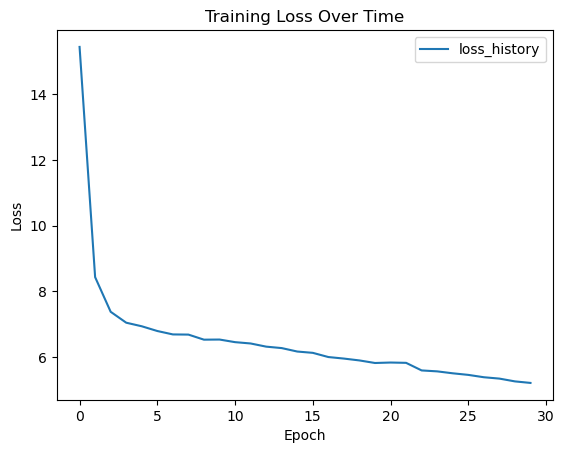

In [495]:
plt.plot(loss_history)
plt.title('Training Loss Over Time')
plt.legend(['loss_history', 'rmse_history'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


# Prediction

---

In [496]:
def prediction(_input, _model):
    _copy = _input.copy()

    # 아무런 전처리 필요없음.

    _copy_mean = np.mean(_copy)
    _result = _copy - _copy_mean

    # sub mean은 학습할때만 해주면 됨.
    # training시의 sub mean은 make dataset에서 해줌.

    for i in tqdm(range(30)):
        _output = _model.predict(
            _result[np.newaxis, i:i+INPUT_DAYS, np.newaxis], verbose=0)
        _result = np.concatenate((_result, _output[0]), axis=0)

    # Subtract mean했던거 다시 더해주기
    _result = _result + _copy_mean
    _summit = _result[-30:]

    plt.figure()
    plt.plot(_result, label='output')
    plt.plot(test, label='input')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

    return _summit


- input 60개로 61번째 예측
- 2번째 ~ 61번째로, 62번째 예측
- 90번째를 예측할 때 까지 반복하고, 61~90번째를 제출

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:01<00:00, 21.40it/s]


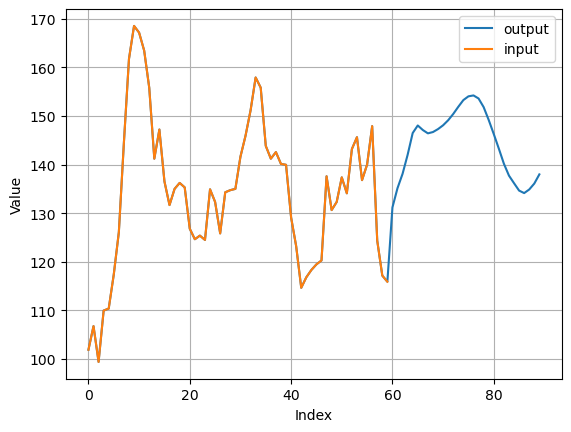

In [497]:
_final_result = prediction(test, first_lstm_model)


## output xlsx file 생성

In [498]:
import datetime

current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
df = pd.DataFrame({'date': np.array(range(1, 31)), 'flux': _final_result})

# DataFrame을 엑셀 파일로 내보내기
file_name = f'/home/competition/data/data/dev/{current_time}_output_{loss_history[-1]}.xlsx'
df.to_excel(file_name, index=False)

model_name = f'/home/competition/data/data/dev/{current_time}_model_{loss_history[-1]}.h5'
first_lstm_model.save(model_name)


/home/competition/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
